In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib as mpl


plt.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.linewidth'] = 2 
set_tex = lambda tex=True: plt.rcParams.update({"text.usetex": tex})
mpl.rc('xtick', labelsize=12) 
mpl.rc('ytick', labelsize=12) 


In [2]:
np.random.seed(1)
rng = lambda n=2: np.random.randn(n, 2)

In [32]:
nu, kappa, rho, dt = 2.43, 2.87, -.94, 1. / 252.

In [59]:
def diffuse_1FSV(s_0, n_samples = 10_000, T = 10.):
    disc_steps = int(T / (20. * dt))
    spot, vol = np.zeros((n_samples, disc_steps + 1)), np.zeros((n_samples, disc_steps + 1))
    spot[:, 0] = s_0
    vol[:, 0] = 1.
    x = np.zeros(n_samples)

    for n in range(1, disc_steps + 1):
        z = rng(n_samples)
        spot[:, n] = spot[:, n - 1] * (1. + vol[:, n - 1] * np.sqrt(dt) * z[:, 0])
        x = x * (1. - kappa * dt) + (rho * z[:, 0] + np.sqrt(1. - rho**2) * z[:, 1]) * np.sqrt(dt)
        vol[:, n] = np.exp(nu * x)

    return spot, vol

In [60]:
s_0 = 1000.

In [61]:
spot, vol = diffuse_1FSV(s_0)

In [63]:
T = 10.

In [67]:
t_grid = np.arange(0., T + 20. * dt, 20. * dt)

In [68]:
t_grid.shape

(127,)

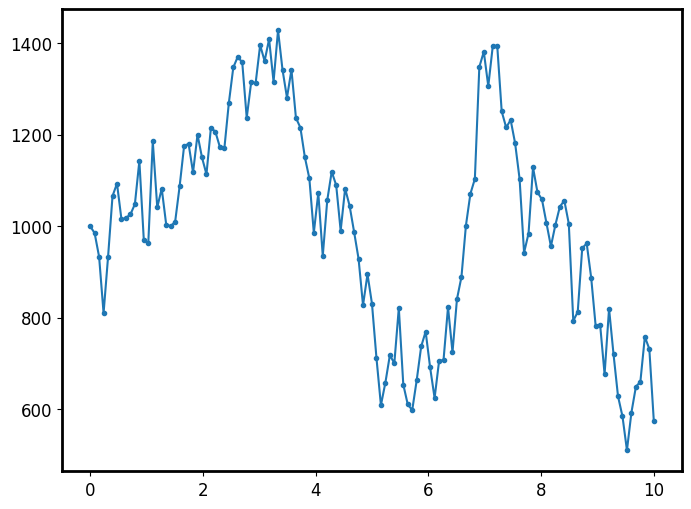

In [69]:
plt.plot(t_grid, spot[0, :], '.-')

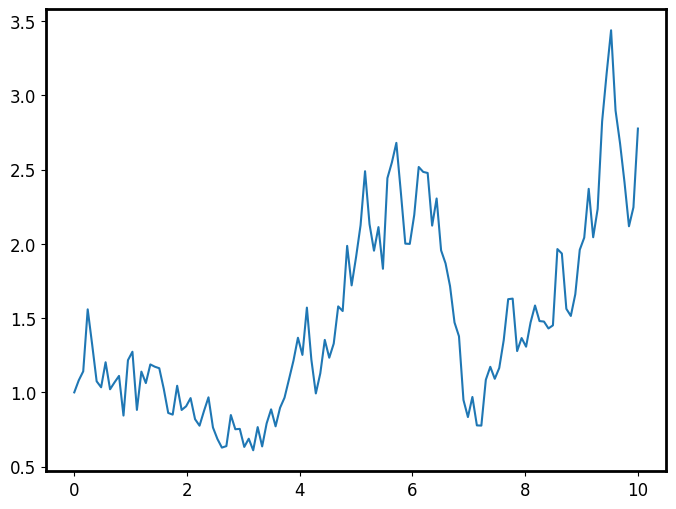

In [70]:
plt.plot(t_grid, vol[0, :])

In [73]:
tenor = np.array([.25, .5, 1., 2., 5., 7., 10.])
tenor_idx = (tenor / (20 * dt)).astype(int)

In [97]:
tenor_ = np.arange(.25, 10.25, .25)
tenor_idx_ = (tenor_ / (20 * dt)).astype(int)

In [102]:
spot_at_tenor = spot[:, tenor_idx_]
vol_at_tenor = vol[:, tenor_idx_]

In [99]:
spot_at_tenor

array([[ 809.83952237, 1093.18015751,  968.740798  , ...,  830.49152565,
        1381.5486855 ,  574.7481248 ],
       [ 999.72511103,  818.36875925,  668.74161081, ..., 1137.15608393,
        1269.28016731,  821.99559967],
       [1012.11802898, 1210.05049215, 1314.17036947, ..., 1275.16079892,
        1799.87922667, 1724.68721927],
       ...,
       [1182.25378919, 1181.8628935 , 1213.62105234, ...,  399.45803877,
         255.72797276,  233.64203675],
       [1002.83493809, 1022.02038312, 1290.91789163, ..., 1448.42766742,
        1440.00424953, 1882.55968427],
       [1013.24161343,  919.75980915,  966.74086528, ...,  861.64045512,
         370.43854732,   49.90350013]])

In [103]:
def get_cov_correl(spot_at_tenor, vol_at_tenor):
    denom_=  (np.diff(spot_at_tenor, axis = 1)**2).cumsum(axis = 1) * (np.diff(vol_at_tenor, axis = 1)**2).cumsum(axis = 1)
    cov = (np.diff(spot_at_tenor, axis = 1) * np.diff(vol_at_tenor, axis = 1)).cumsum(axis = 1)
    return cov, cov / np.sqrt(denom_) 

In [104]:
cov, correl = get_cov_correl(spot_at_tenor, vol_at_tenor)

In [108]:
correl.mean(axis = 0)

array([-0.7774    , -0.87461186, -0.90002408, -0.91006645, -0.91469495,
       -0.91602975, -0.9163921 , -0.91554727, -0.91468983, -0.91337344,
       -0.91146687, -0.90928452, -0.90652678, -0.90358832, -0.90089586,
       -0.89825593, -0.89563674, -0.892863  , -0.88883108, -0.88584167,
       -0.88288473, -0.88033786, -0.87762186, -0.87470437, -0.8717969 ,
       -0.86779502, -0.86484234, -0.86181754, -0.85888311, -0.85630128,
       -0.8532806 , -0.85056963, -0.84701897, -0.84450263, -0.84198126,
       -0.8393179 , -0.836735  , -0.83421564, -0.83092031])

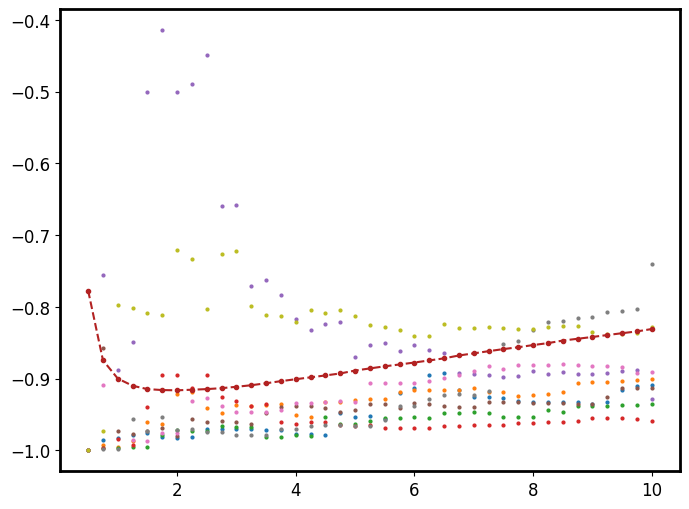

In [126]:
idx = [k for k in range(10) if k != 4]
for i in idx:
    plt.plot(tenor_[1:], correl[i, :], '.', markersize = 4)
plt.plot(tenor_[1:], correl.mean(0), '.--', color = 'firebrick')